In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
from pyro.infer.autoguide import AutoNormal

/tmp/ipykernel_3514/3865845321.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/sandoar/miniconda3/envs/model/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
class RaceNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=28, output_dim=2):
        super(RaceNet, self).__init__()

        self.net = nn.Sequential(
            PyroModule[nn.Linear](input_dim, hidden_dim),
            nn.ReLU(),
            PyroModule[nn.Linear](hidden_dim, output_dim)
        )

    def forward(self, races1, races2):

        x = torch.cat((races1, races2), dim=1)

        return self.net(x)

In [19]:
def model(obs, ids1, ids2, races1, races2, num_coaches):
    """
    Inputs:
        obs: obs: A 1D tensor of observed data. The length should be equal to the number of games played.
             Represents the outcome of a game in the eyes of coach 1, i.e. coach 1 wins: obs = 1, coach 2 wins: obs = -1.
        ids1: A 1D tensor of the same length as obs. Contains the index of the first coach in each game.
        ids2: A 1D tensor of the same length as obs. Contains the index of the second coach in each game.
        num_coaches: The number of coaches in the dataset.

    Output: A 1D tensor of the same length as "obs". Represents a sample from difference in performance between the two coaches.
    """

    hyper_sigma = 1/8
    
    coach_mu_skill = 0
    coach_sigma_skill = 1

    num_games = obs.shape[0]
    num_races = len(races1[0])

    NN = RaceNet(2*num_races)

    # Sample skills for each coach using a plate for coaches
    with pyro.plate('coaches', num_coaches):
        coach_skills = pyro.sample("coach_skills", dist.Normal(coach_mu_skill, coach_sigma_skill))
    
    with pyro.plate('matches', num_games):
        # Gather the skills for the competing coaches in each match
        coach1_skills = coach_skills[ids1]
        coach2_skills = coach_skills[ids2]

        # Get racial bias
        biases = NN(races1, races2)
        coach1_biases = biases[:, 0]
        coach2_biases = biases[:, 1]

        # Sample performances for the coaches in each match
        coach1_perf = pyro.sample('coach1_perf', dist.Normal(coach1_skills - coach1_biases , hyper_sigma))
        coach2_perf = pyro.sample('coach2_perf', dist.Normal(coach2_skills - coach2_biases, hyper_sigma))

        # Compute the performance difference
        perf_diff = coach1_perf - coach2_perf

        # Sample the observed outcomes
        y = pyro.sample("y_coach1_win", dist.Normal(perf_diff, hyper_sigma), obs=obs)

    return y

In [4]:
# load and format data
df = pd.read_csv('../data/X_train.csv')

# make a list of unique coaches
coaches1 = df['team1_coach_id']
coaches2 = df['team2_coach_id']
unique_coaches = pd.concat([coaches1, coaches2]).unique()
unique_coaches.sort()

num_coaches = len(unique_coaches)

coach_winrates = np.zeros(num_coaches)
coach_num_matches = np.zeros(num_coaches)

for id, coach_id in enumerate(unique_coaches):
    coach1_df = df[df['team1_coach_id'] == coach_id]

    coach_winrates[id] += 0.5 * (coach1_df["team1_win"] == 0).sum()
    coach_winrates[id] += (coach1_df["team1_win"] == 1).sum()

    coach2_df = df[df['team2_coach_id'] == coach_id]
    coach_winrates[id] += 0.5 * (coach1_df["team2_win"] == 0).sum()
    coach_winrates[id] += (coach2_df["team2_win"] == 1).sum()

    coach_winrates[id] = coach_winrates[id] / (len(coach1_df) + len(coach2_df))
    coach_num_matches[id] = len(coach1_df) + len(coach2_df)

indices = np.lexsort((unique_coaches, coach_winrates, coach_num_matches))

sorted_coaches = unique_coaches[indices[::-1]]
sorted_winrates = coach_winrates[indices[::-1]]
sorted_num_matches = coach_num_matches[indices[::-1]]

coach_dict = {coach: i for i, coach in enumerate(sorted_coaches)}

# make variables for the model sorted by winrate
id1 = torch.tensor(coaches1.map(coach_dict).values).long()
id2 = torch.tensor(coaches2.map(coach_dict).values).long()

obs = torch.tensor(df['team1_win'].values)
num_games = len(obs)

race1 = df['team1_race_name'].values
race2 = df['team2_race_name'].values

unique_categories1, indices1 = np.unique(race1 , return_inverse=True)
unique_categories2, indices2 = np.unique(race2 , return_inverse=True)

indices_tensor1 = torch.tensor(indices1)
num_categories = len(unique_categories1)
race1_one_hot = torch.nn.functional.one_hot(indices_tensor1, num_classes=num_categories).float()

indices_tensor2 = torch.tensor(indices2)
race2_one_hot = torch.nn.functional.one_hot(indices_tensor2, num_classes=num_categories).float()


In [22]:
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model)

svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
num_games = 12

step_list = []
loss_list = []

for step in range(num_steps):
    loss = svi.step(obs, id1, id2, race1_one_hot, race2_one_hot, num_coaches)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")
        loss_list.append(loss)
        step_list.append(step)


Step 0 : loss = 2015673.1166992188
Step 100 : loss = 634686.3283691406
Step 200 : loss = 550281.9416503906
Step 300 : loss = 505328.89501953125
Step 400 : loss = 606721.56640625
Step 500 : loss = 521117.68994140625
Step 600 : loss = 531555.8959960938
Step 700 : loss = 524582.4079589844
Step 800 : loss = 639881.7868652344
Step 900 : loss = 501027.7048339844
Step 1000 : loss = 516384.005859375
Step 1100 : loss = 612903.6572265625
Step 1200 : loss = 485867.0166015625
Step 1300 : loss = 563944.82421875
Step 1400 : loss = 653483.1188964844
Step 1500 : loss = 491229.0017089844
Step 1600 : loss = 493271.7390136719
Step 1700 : loss = 495261.2194824219
Step 1800 : loss = 475153.4968261719
Step 1900 : loss = 589454.8803710938
Step 2000 : loss = 523026.3671875
Step 2100 : loss = 485568.1474609375
Step 2200 : loss = 501391.55810546875
Step 2300 : loss = 480781.1474609375
Step 2400 : loss = 532949.8930664062
Step 2500 : loss = 472986.7385253906
Step 2600 : loss = 589655.8854980469
Step 2700 : loss 

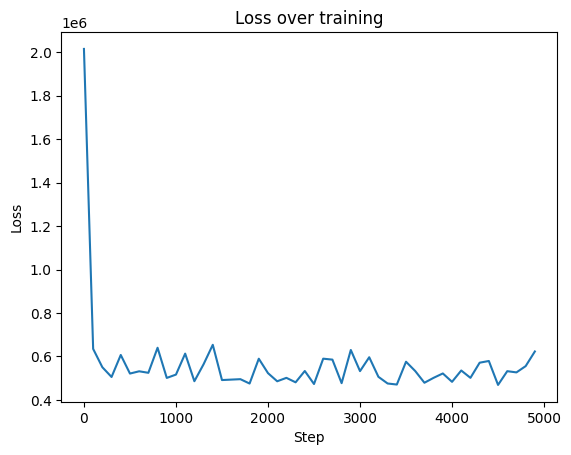

In [23]:
# plot the loss
plt.plot(step_list, loss_list)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss over training")
plt.show()


In [24]:
predictive = Predictive(model, guide=guide, num_samples=2000)

samples = predictive(obs,id1, id2, race1_one_hot, race2_one_hot, num_coaches)

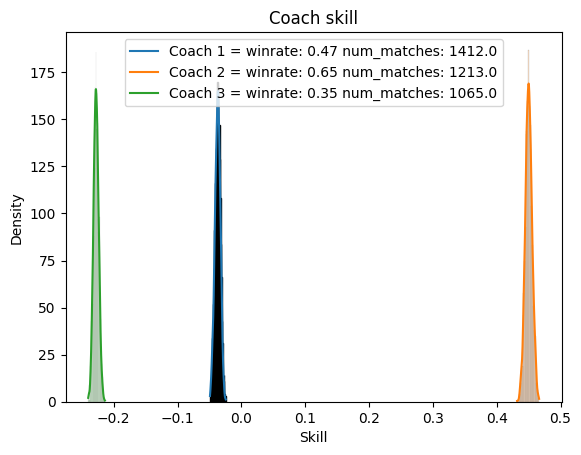

In [25]:
labels = []
for i in range(3):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1} = winrate: {sorted_winrates[i]:.2f} num_matches: {sorted_num_matches[i]}")
    
plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()
